# GLM & AnCova (+ Effect Size)

### Mutation Rate

In [1]:
# SETUP
import sys
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.genmod.families import Gaussian
from scipy.stats import zscore

In [5]:
#Upload sim_code.py output:
df = pd.read_csv('new_F.csv')

#Convert mut rate to per site per year
df['output_mut_new'] = df['Variants'] / (df['GenSize'] * 300)
#Filter
df = df[(df['Variants'] > 0) & (df['output_mut_new'] > 0)]

#DEFINE
# Topology Balance and Topology Branch Ratio
df['Topology_Balance'] = df['tree_topology'].apply(lambda x: 'Balanced' if x.startswith('b') else 'Unbalanced')
df['Topology_Branch_Ratio'] = df['tree_topology'].apply(lambda x: 'Short' if 'S' in x else 'Long')

df['Topology_Type'] = df['tree_topology'].apply(lambda x: 'Balanced' if x.startswith('b') else 'Unbalanced')
df['Branch_Length_Type'] = df['tree_topology'].apply(lambda x: 'Short' if 'S' in x else 'Long')

#NUM BRANCH as int
df['Num_Terminal_Branches'] = df['tree_topology'].str.extract(r'(\d+)$').astype(int)

# model params
df['Elongation_Parameter'] = df['StD'].apply(lambda x: 'Structured' if x == 0 else 'Stochastic')
df['Branching_Parameter'] = df['biasVar'].apply(lambda x: 'Biased' if x == 0.5 else 'Unbiased')

#Check
print(len(df))

12102


In [6]:
#Z-Score Transformation

# Make branch ratio numerical
df['Topology_Branch_Ratio'] = df['Topology_Branch_Ratio'].map({'Short': 0.5, 'Long': 2.0})


df['input_mut_rate'] = zscore(df['input_mut_rate'])
df['Topology_Balance'] = zscore(df['Topology_Balance'].map({'Balanced': 0, 'Unbalanced': 1}))
df['Topology_Branch_Ratio'] = zscore(df['Topology_Branch_Ratio'])
df['StD'] = zscore(df['StD'])
df['biasVar'] = zscore(df['biasVar'])
df['Num_Terminal_Branches'] = zscore(df['Num_Terminal_Branches'])
df['output_mut_new'] = zscore(df['output_mut_new'])

In [12]:
# MAKE GLM MODEL

glm_model = smf.glm(formula='output_mut_rate ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + '
                             'StD + biasVar + Num_Terminal_Branches + '
                             'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
                             'input_mut_rate:StD + input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
                             'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
                             'Topology_Balance:biasVar + Topology_Balance:Num_Terminal_Branches + '
                             'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
                             'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
                             'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
                     data=df, family=sm.families.Gaussian()).fit()

# Model summary
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        output_mut_rate   No. Observations:                12102
Model:                            GLM   Df Residuals:                    12080
Model Family:                Gaussian   Df Model:                           21
Link Function:               identity   Scale:                      5.9727e-14
Method:                          IRLS   Log-Likelihood:             1.6709e+05
Date:                Mon, 18 Nov 2024   Deviance:                   7.2150e-10
Time:                        14:58:35   Pearson chi2:                 7.22e-10
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9640
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

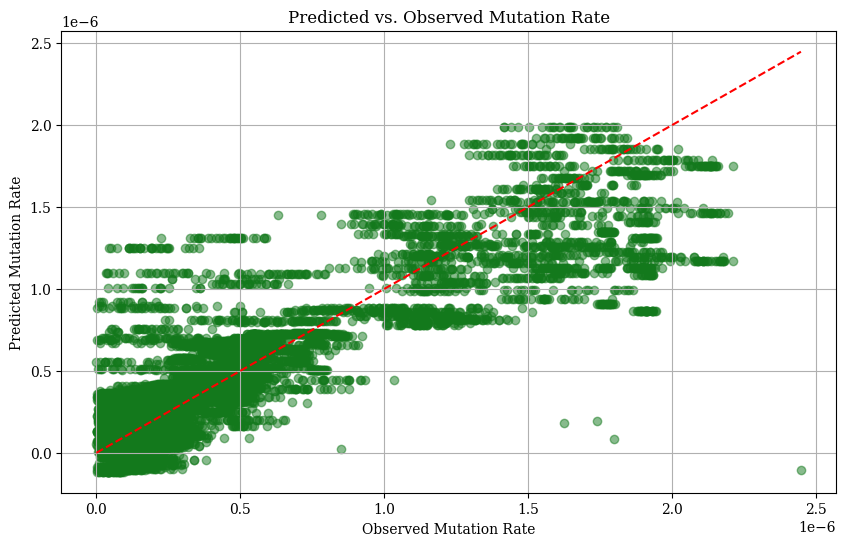

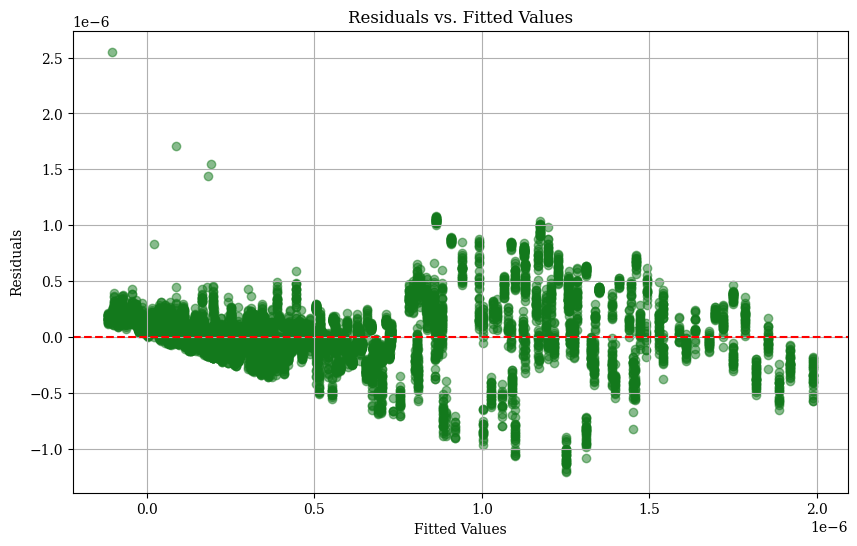

In [13]:
#PLOT GLM TESTS...
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#aesthetic
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
forest_green = "#13791C"
light_green = '#38E737'

# predict using glm
df['Predicted'] = glm_model.fittedvalues

# Predicted vs Observed plot
plt.figure(figsize=(10, 6))
plt.scatter(df['output_mut_rate'], df['Predicted'], color=forest_green, alpha=0.5)
plt.plot([df['output_mut_rate'].min(), df['output_mut_rate'].max()],
         [df['output_mut_rate'].min(), df['output_mut_rate'].max()],
         color='red', linestyle='--')  # Reference line
plt.xlabel('Observed Mutation Rate')
plt.ylabel('Predicted Mutation Rate')
plt.title('Predicted vs. Observed Mutation Rate')
plt.grid(True)
plt.show()

# Residuals vs Fitted 
df['Residuals'] = df['output_mut_rate'] - df['Predicted']
plt.figure(figsize=(10, 6))
plt.scatter(df['Predicted'], df['Residuals'], color=forest_green, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Reference line
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.grid(True)
plt.show()


In [14]:
# CALC PARTIAL ETA SQUARED

# residual dev from model
residual_deviance = glm_model.deviance
df_residual = glm_model.df_resid

#reduced formulaes
reduced_formulas = {
    'input_mut_rate': 'output_mut_rate ~ Topology_Balance + Topology_Branch_Ratio + StD + biasVar + Num_Terminal_Branches + '
                      'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
                      'Topology_Balance:biasVar + Topology_Balance:Num_Terminal_Branches + '
                      'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
                      'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
                      'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'Topology_Balance': 'output_mut_rate ~ input_mut_rate + Topology_Branch_Ratio + StD + biasVar + Num_Terminal_Branches + '
                        'input_mut_rate:Topology_Branch_Ratio + input_mut_rate:StD + '
                        'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
                        'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
                        'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
                        'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'Topology_Branch_Ratio': 'output_mut_rate ~ input_mut_rate + Topology_Balance + StD + biasVar + Num_Terminal_Branches + '
                             'input_mut_rate:Topology_Balance + input_mut_rate:StD + '
                             'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
                             'Topology_Balance:StD + Topology_Balance:biasVar + '
                             'Topology_Balance:Num_Terminal_Branches + StD:biasVar + '
                             'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'StD': 'output_mut_rate ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + biasVar + Num_Terminal_Branches + '
           'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
           'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
           'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:biasVar + '
           'Topology_Balance:Num_Terminal_Branches + Topology_Branch_Ratio:biasVar + '
           'Topology_Branch_Ratio:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'biasVar': 'output_mut_rate ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + StD + Num_Terminal_Branches + '
               'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
               'input_mut_rate:StD + input_mut_rate:Num_Terminal_Branches + '
               'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
               'Topology_Balance:Num_Terminal_Branches + Topology_Branch_Ratio:StD + '
               'Topology_Branch_Ratio:Num_Terminal_Branches + StD:Num_Terminal_Branches',
    'Num_Terminal_Branches': 'output_mut_rate ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + StD + biasVar + '
                             'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
                             'input_mut_rate:StD + input_mut_rate:biasVar + '
                             'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
                             'Topology_Balance:biasVar + Topology_Branch_Ratio:StD + '
                             'Topology_Branch_Ratio:biasVar + StD:biasVar'
}

#sum of squares using reduced models
sum_sq_dict = {}
for term, formula in reduced_formulas.items():
    reduced_model = smf.glm(formula=formula, data=df, family=sm.families.Gaussian()).fit()
    deviance_diff = reduced_model.deviance - residual_deviance
    sum_sq_dict[term] = deviance_diff

# dataframe
anova_results = pd.DataFrame(sum_sq_dict.items(), columns=['Variable', 'sum_sq'])
anova_results['df'] = 1

# calc eta
anova_results['Partial_Eta_Squared'] = anova_results['sum_sq'] / (anova_results['sum_sq'] + residual_deviance)


print(anova_results)


                Variable        sum_sq  df  Partial_Eta_Squared
0         input_mut_rate  9.803772e-10   1             0.576055
1       Topology_Balance  3.474537e-10   1             0.325040
2  Topology_Branch_Ratio  1.720492e-10   1             0.192545
3                    StD  1.142379e-09   1             0.612903
4                biasVar  9.341487e-12   1             0.012782
5  Num_Terminal_Branches  2.790935e-10   1             0.278927


## Markdown

In [17]:
#Upload RF data from full_newick.R
df_phylo = pd.read_csv('nj_full.csv')

# remove duplicates
df_phylo = df_phylo.drop_duplicates()

#define again

# Topology Balance and Topology Branch Ratio
df_phylo['Topology_Balance'] = df_phylo['tree_topology'].apply(lambda x: 'Balanced' if x.startswith('b') else 'Unbalanced')
df_phylo['Topology_Branch_Ratio'] = df_phylo['tree_topology'].apply(lambda x: 'Short' if 'S' in x else 'Long')

# num term branch as int
df_phylo['Num_Terminal_Branches'] = df_phylo['tree_topology'].str.extract(r'(\d+)$').astype(int)

# model param
df_phylo['Elongation_Parameter'] = df_phylo['StD'].apply(lambda x: 'Structured' if x == 5 else 'Stochastic')
df_phylo['Branching_Parameter'] = df_phylo['biasVar'].apply(lambda x: 'Biased' if x == 0.5 else 'Unbiased')


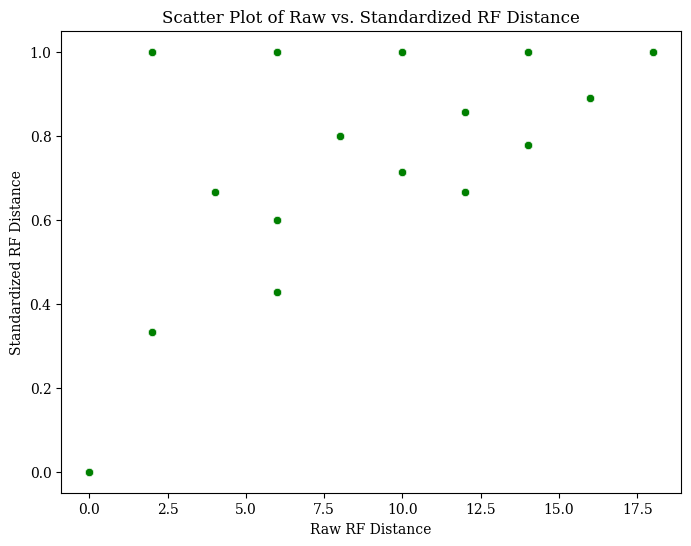

In [18]:
#Standardize RF dist

#Define Max RF distances
max_rf_distances = {
    4: 2,
    6: 6,
    8: 10,
    10: 14,
    12: 18
}

#Standardize RF Distance
df_phylo['Standardized_RF_Distance'] = df_phylo.apply(
    lambda row: row['RF_Distance'] / max_rf_distances[row['Num_Terminal_Branches']],
    axis=1
)

#CHECK STANDARDIZATION
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RF_Distance', y='Standardized_RF_Distance', data=df_phylo, color='green')
plt.title('Scatter Plot of Raw vs. Standardized RF Distance')
plt.xlabel('Raw RF Distance')
plt.ylabel('Standardized RF Distance')
plt.show()


In [19]:

# Z-score standardise
df_phylo['RF_Distance'] = zscore(df_phylo['RF_Distance'])
df_phylo['input_mut_rate'] = zscore(df_phylo['input_mut_rate'])
df_phylo['Num_Terminal_Branches'] = zscore(df_phylo['Num_Terminal_Branches'])
df_phylo['StD'] = zscore(df_phylo['StD'])
df_phylo['biasVar'] = zscore(df_phylo['biasVar'])

# branch ratio numerical !
df_phylo['Topology_Branch_Ratio'] = df_phylo['Topology_Branch_Ratio'].map({'Short': 1/2, 'Long': 2/1})
df_phylo['Topology_Branch_Ratio'] = zscore(df_phylo['Topology_Branch_Ratio'])

# RF dist glm
formula_rf = (
    'RF_Distance ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + '
    'StD + biasVar + Num_Terminal_Branches + '
    'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
    'input_mut_rate:StD + input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
    'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
    'Topology_Balance:biasVar + Topology_Balance:Num_Terminal_Branches + '
    'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
    'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
    'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches'
)

glm_model_rf = smf.glm(formula=formula_rf, data=df_phylo, family=sm.families.Gaussian()).fit()

# summarise
print(glm_model_rf.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            RF_Distance   No. Observations:                13914
Model:                            GLM   Df Residuals:                    13892
Model Family:                Gaussian   Df Model:                           21
Link Function:               identity   Scale:                        0.017061
Method:                          IRLS   Log-Likelihood:                 8589.8
Date:                Mon, 18 Nov 2024   Deviance:                       237.00
Time:                        15:08:08   Pearson chi2:                     237.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

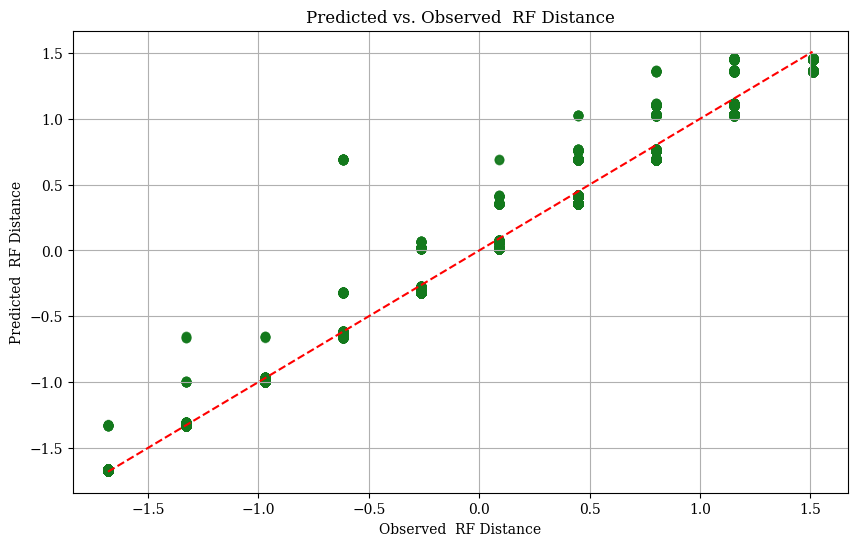

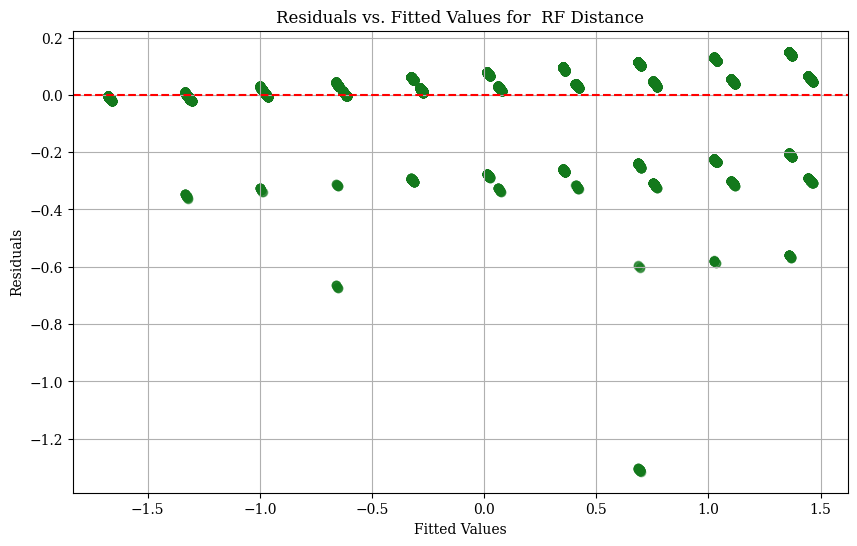

In [20]:
#Plot glm tests RF

# predict use RF glm
df_phylo['Predicted_RF'] = glm_model_rf.fittedvalues

# Predict vs Observed RF plot
plt.figure(figsize=(10, 6))
plt.scatter(df_phylo['RF_Distance'], df_phylo['Predicted_RF'], color='#13791C', alpha=0.5)
plt.plot([df_phylo['RF_Distance'].min(), df_phylo['RF_Distance'].max()],
         [df_phylo['RF_Distance'].min(), df_phylo['RF_Distance'].max()],
         color='red', linestyle='--')  # Reference line
plt.xlabel('Observed  RF Distance')
plt.ylabel('Predicted  RF Distance')
plt.title('Predicted vs. Observed  RF Distance')
plt.grid(True)
plt.show()

# Residuals vs Fitted Values RF 
df_phylo['Residuals_RF'] = df_phylo['RF_Distance'] - df_phylo['Predicted_RF']
plt.figure(figsize=(10, 6))
plt.scatter(df_phylo['Predicted_RF'], df_phylo['Residuals_RF'], color='#13791C', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Reference line
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values for  RF Distance')
plt.grid(True)
plt.show()

In [22]:
#Partial ETA RF

#residual dev
residual_deviance_rf = glm_model_rf.deviance
df_residual_rf = glm_model_rf.df_resid

# reduced formulae
reduced_formulas_rf = {
    'input_mut_rate': 'RF_Distance ~ Topology_Balance + Topology_Branch_Ratio + StD + biasVar + Num_Terminal_Branches + '
                      'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
                      'Topology_Balance:biasVar + Topology_Balance:Num_Terminal_Branches + '
                      'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
                      'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
                      'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'Topology_Balance': 'RF_Distance ~ input_mut_rate + Topology_Branch_Ratio + StD + biasVar + Num_Terminal_Branches + '
                        'input_mut_rate:Topology_Branch_Ratio + input_mut_rate:StD + '
                        'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
                        'Topology_Branch_Ratio:StD + Topology_Branch_Ratio:biasVar + '
                        'Topology_Branch_Ratio:Num_Terminal_Branches + StD:biasVar + '
                        'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'Topology_Branch_Ratio': 'RF_Distance ~ input_mut_rate + Topology_Balance + StD + biasVar + Num_Terminal_Branches + '
                             'input_mut_rate:Topology_Balance + input_mut_rate:StD + '
                             'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
                             'Topology_Balance:StD + Topology_Balance:biasVar + '
                             'Topology_Balance:Num_Terminal_Branches + StD:biasVar + '
                             'StD:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'StD': 'RF_Distance ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + biasVar + Num_Terminal_Branches + '
           'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
           'input_mut_rate:biasVar + input_mut_rate:Num_Terminal_Branches + '
           'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:biasVar + '
           'Topology_Balance:Num_Terminal_Branches + Topology_Branch_Ratio:biasVar + '
           'Topology_Branch_Ratio:Num_Terminal_Branches + biasVar:Num_Terminal_Branches',
    'biasVar': 'RF_Distance ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + StD + Num_Terminal_Branches + '
               'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
               'input_mut_rate:StD + input_mut_rate:Num_Terminal_Branches + '
               'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
               'Topology_Balance:Num_Terminal_Branches + Topology_Branch_Ratio:StD + '
               'Topology_Branch_Ratio:Num_Terminal_Branches + StD:Num_Terminal_Branches',
    'Num_Terminal_Branches': 'RF_Distance ~ input_mut_rate + Topology_Balance + Topology_Branch_Ratio + StD + biasVar + '
                             'input_mut_rate:Topology_Balance + input_mut_rate:Topology_Branch_Ratio + '
                             'input_mut_rate:StD + input_mut_rate:biasVar + '
                             'Topology_Balance:Topology_Branch_Ratio + Topology_Balance:StD + '
                             'Topology_Balance:biasVar + Topology_Branch_Ratio:StD + '
                             'Topology_Branch_Ratio:biasVar + StD:biasVar'
}

# sum squares
sum_sq_dict_rf = {}
for term, formula in reduced_formulas_rf.items():
    reduced_model_rf = smf.glm(formula=formula, data=df_phylo, family=sm.families.Gaussian()).fit()
    deviance_diff_rf = reduced_model_rf.deviance - residual_deviance_rf
    sum_sq_dict_rf[term] = deviance_diff_rf

# dataframe
anova_results_rf = pd.DataFrame(sum_sq_dict_rf.items(), columns=['Variable', 'sum_sq'])
anova_results_rf['df'] = 1

#partial eta calc
anova_results_rf['Partial_Eta_Squared'] = anova_results_rf['sum_sq'] / (anova_results_rf['sum_sq'] + residual_deviance_rf)
print(anova_results_rf)


                Variable        sum_sq  df  Partial_Eta_Squared
0         input_mut_rate      0.049039   1             0.000207
1       Topology_Balance    405.640469   1             0.631205
2  Topology_Branch_Ratio     11.076224   1             0.044648
3                    StD      0.267235   1             0.001126
4                biasVar      0.227578   1             0.000959
5  Num_Terminal_Branches  13293.542313   1             0.982484
